# 🔍 Feature Exploration & Analysis

This notebook allows you to explore and understand all features BEFORE loading them into a model.

## What You'll Learn:
1. **Feature Overview**: What each feature represents
2. **Statistical Properties**: Distribution, outliers, missing values
3. **Correlations**: How features relate to each other and the target
4. **Quality Assessment**: Which features are reliable vs problematic
5. **Feature Importance**: Early insights into predictive power


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Interactive visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Analysis
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Settings
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("📊 Feature Exploration Notebook Ready!")
print("✨ Now with interactive visualizations!")

📊 Feature Exploration Notebook Ready!
✨ Now with interactive visualizations!


## 1. Load Features (Run Pipeline First if Needed)

In [2]:
# Check if processed features exist
data_path = Path('/Users/diyagamah/Documents/nba_props_model/data')
processed_file = data_path / 'processed' / 'player_features_2023_24.csv'

if not processed_file.exists():
    print("⚠️ Processed features not found!")
    print("\n👉 Please run notebook '00_run_feature_pipeline.ipynb' first")
    print("   This will generate the features needed for exploration.")
    raise FileNotFoundError("Run the feature pipeline notebook first!")
else:
    # Load features
    df = pd.read_csv(processed_file)
    print(f"✅ Loaded features: {df.shape[0]} players, {df.shape[1]} columns")
    
    # Separate features from identifiers and target
    id_cols = ['Player', 'Team']
    target_col = 'PRA_estimate' if 'PRA_estimate' in df.columns else None
    
    feature_cols = [col for col in df.columns if col not in id_cols]
    if target_col:
        feature_cols = [col for col in feature_cols if col != target_col]
    
    print(f"\n📋 Data Summary:")
    print(f"  - Players: {len(df)}")
    print(f"  - Features: {len(feature_cols)}")
    if target_col:
        print(f"  - Target: {target_col}")

✅ Loaded features: 503 players, 27 columns

📋 Data Summary:
  - Players: 503
  - Features: 24
  - Target: PRA_estimate


## 2. Feature Overview & Definitions

In [3]:
# Define what each feature represents
feature_definitions = {
    # Core Performance (Tier 1)
    'USG_percent': 'Usage Rate - % of team possessions used by player',
    'PSA': 'Points per Shot Attempt - Scoring efficiency metric',
    'MIN': 'Minutes played per game',
    'AST_percent': 'Assist Percentage - % of teammate FGs assisted',
    'AST_to_USG_Ratio': 'Assist to Usage Ratio - Playmaking vs scoring balance',
    'fgDR_percent': 'Defensive Rebound % - % of available defensive rebounds',
    'fgOR_percent': 'Offensive Rebound % - % of available offensive rebounds', 
    'Total_REB_percent': 'Total Rebound % - Combined offensive + defensive',
    'eFG_percent': 'Effective Field Goal % - Shooting efficiency adjusted for 3s',
    'TOV_percent': 'Turnover % - Turnovers per 100 possessions',
    'Defensive_Activity': 'Combined blocks + steals percentage',
    
    # Contextual (Tier 2)
    'Minutes_Season_Avg': 'Season average minutes per game',
    'Minutes_Category': 'Role category based on minutes (Bench/Rotation/Starter/Star)',
    'Position_Inferred': 'Position inferred from stats (Guard/Forward/Big)',
    'Player_Role': 'Role based on usage and minutes (Primary/Secondary/Role/Bench)',
    
    # Temporal (Tier 3)
    'Consistency_Score': 'How consistent player performance is',
    'Usage_Stability': 'Stability of usage rate over time',
    'Performance_Tier': 'Overall performance level ranking',
    'Opportunity_Score': 'Combined opportunity metric (minutes × usage × efficiency)'
}

# Show available features grouped by tier
print("📊 AVAILABLE FEATURES BY TIER:")
print("="*60)

tiers = {
    '🎯 Core Performance (Tier 1)': ['USG_percent', 'PSA', 'MIN', 'AST_percent', 'AST_to_USG_Ratio', 
                                     'fgDR_percent', 'fgOR_percent', 'Total_REB_percent', 
                                     'eFG_percent', 'TOV_percent', 'Defensive_Activity'],
    '🎮 Contextual (Tier 2)': ['Minutes_Season_Avg', 'Player_Role'],
    '📈 Temporal (Tier 3)': ['Consistency_Score', 'Usage_Stability', 'Performance_Tier', 'Opportunity_Score']
}

for tier_name, tier_features in tiers.items():
    print(f"\n{tier_name}:")
    available = [f for f in tier_features if f in df.columns]
    missing = [f for f in tier_features if f not in df.columns]
    
    for feat in available:
        definition = feature_definitions.get(feat, 'No definition available')
        print(f"  ✓ {feat:20s} - {definition}")
    
    if missing:
        for feat in missing:
            print(f"  ✗ {feat:20s} - NOT AVAILABLE")

📊 AVAILABLE FEATURES BY TIER:

🎯 Core Performance (Tier 1):
  ✓ USG_percent          - Usage Rate - % of team possessions used by player
  ✓ PSA                  - Points per Shot Attempt - Scoring efficiency metric
  ✓ MIN                  - Minutes played per game
  ✓ AST_percent          - Assist Percentage - % of teammate FGs assisted
  ✓ AST_to_USG_Ratio     - Assist to Usage Ratio - Playmaking vs scoring balance
  ✓ fgDR_percent         - Defensive Rebound % - % of available defensive rebounds
  ✓ fgOR_percent         - Offensive Rebound % - % of available offensive rebounds
  ✓ Total_REB_percent    - Total Rebound % - Combined offensive + defensive
  ✓ eFG_percent          - Effective Field Goal % - Shooting efficiency adjusted for 3s
  ✓ TOV_percent          - Turnover % - Turnovers per 100 possessions
  ✓ Defensive_Activity   - Combined blocks + steals percentage

🎮 Contextual (Tier 2):
  ✓ Player_Role          - Role based on usage and minutes (Primary/Secondary/Role/Bench)
 

## 3. Statistical Summary

In [4]:
# Generate comprehensive statistical summary
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

# Create enhanced describe
stats_df = df[numeric_features].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

# Add additional statistics
stats_df['missing'] = df[numeric_features].isna().sum()
stats_df['missing_%'] = (stats_df['missing'] / len(df)) * 100
stats_df['zeros'] = (df[numeric_features] == 0).sum()
stats_df['zeros_%'] = (stats_df['zeros'] / len(df)) * 100
stats_df['unique'] = df[numeric_features].nunique()
stats_df['skew'] = df[numeric_features].skew()
stats_df['kurtosis'] = df[numeric_features].kurtosis()

# Show summary
print("📊 FEATURE STATISTICS SUMMARY:")
print("="*80)
print("\nKey Metrics for Top Features:")
print("-"*80)

# Select important columns to display
display_cols = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_%', 'zeros_%', 'skew']
print(stats_df[display_cols].head(10).round(2))

📊 FEATURE STATISTICS SUMMARY:

Key Metrics for Top Features:
--------------------------------------------------------------------------------
                      mean     std    min     25%     50%      75%      max  \
USG_percent          17.90    5.95    5.6   13.50   16.70    21.35    40.30   
PSA                 113.92   13.72   54.3  107.10  114.70   122.00   155.00   
MIN                1132.83  784.99  100.0  423.50  973.00  1785.00  2987.00   
AST_percent          14.35    8.26    2.8    7.80   12.20    19.40    44.40   
AST_to_USG_Ratio      0.78    0.32    0.2    0.55    0.73     0.96     1.98   
fgDR_percent         12.89    4.82    2.4    9.50   11.70    15.80    31.80   
fgOR_percent          4.70    3.45    0.0    2.15    3.40     6.45    19.60   
Total_REB_percent    17.59    7.62    4.4   12.10   15.40    21.65    51.40   
eFG_percent          54.11    7.10   26.2   50.45   54.30    58.10    78.00   
TOV_percent          12.02    3.67    2.6    9.80   11.70    13.85  

## 4. Feature Distributions

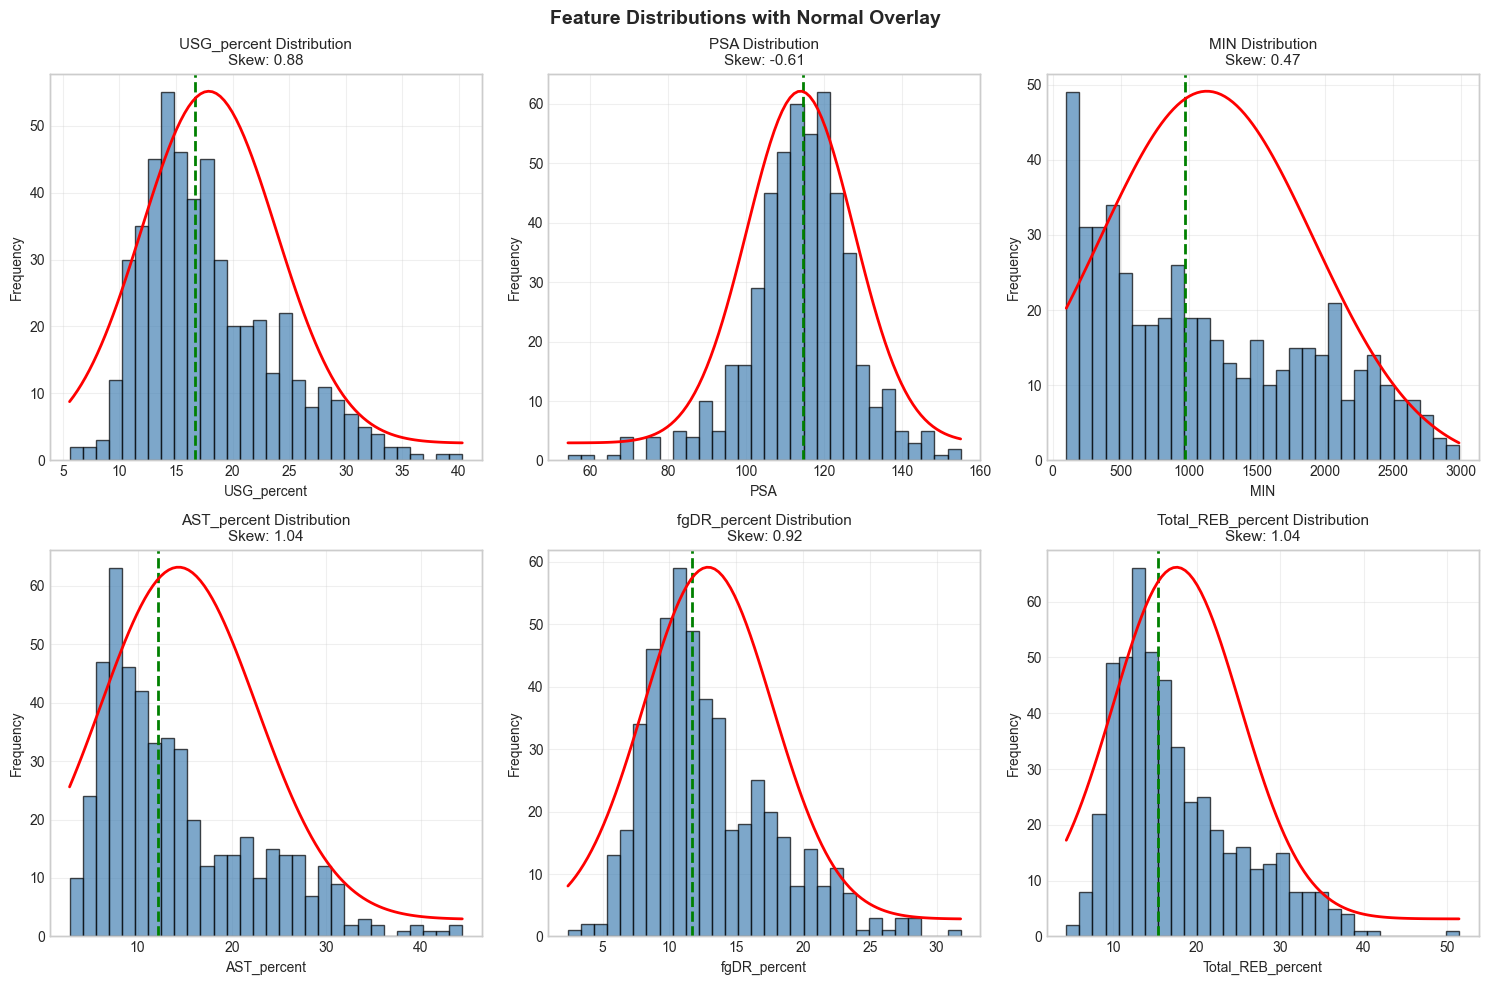


📊 NORMALITY TESTS (Shapiro-Wilk):
USG_percent         : p=0.0000 - ✗ Not Normal
PSA                 : p=0.0000 - ✗ Not Normal
MIN                 : p=0.0000 - ✗ Not Normal
AST_percent         : p=0.0000 - ✗ Not Normal
fgDR_percent        : p=0.0000 - ✗ Not Normal
Total_REB_percent   : p=0.0000 - ✗ Not Normal


In [5]:
# Visualize distributions of key features
key_features = ['USG_percent', 'PSA', 'MIN', 'AST_percent', 'fgDR_percent', 'Total_REB_percent']
key_features = [f for f in key_features if f in numeric_features]

if len(key_features) >= 6:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
else:
    fig, axes = plt.subplots(1, len(key_features), figsize=(5*len(key_features), 5))
    if len(key_features) == 1:
        axes = [axes]

for idx, feat in enumerate(key_features[:6]):
    ax = axes[idx]
    
    # Plot histogram
    data = df[feat].dropna()
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    
    # Add normal distribution overlay
    mu, std = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    ax2 = ax.twinx()
    ax2.plot(x, stats.norm.pdf(x, mu, std) * len(data) * (data.max()-data.min())/30, 
             'r-', linewidth=2, label='Normal')
    
    # Add median line
    ax.axvline(data.median(), color='green', linestyle='--', linewidth=2, label='Median')
    
    # Labels
    ax.set_xlabel(feat, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{feat} Distribution\nSkew: {data.skew():.2f}', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Remove y-axis for normal curve
    ax2.set_yticks([])

plt.suptitle('Feature Distributions with Normal Overlay', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Check for normality
print("\n📊 NORMALITY TESTS (Shapiro-Wilk):")
print("="*50)
for feat in key_features:
    data = df[feat].dropna()
    if len(data) > 3:
        stat, p_value = stats.shapiro(data[:5000])  # Limit sample size for test
        normal = "✓ Normal" if p_value > 0.05 else "✗ Not Normal"
        print(f"{feat:20s}: p={p_value:.4f} - {normal}")

## 5. Correlation Analysis

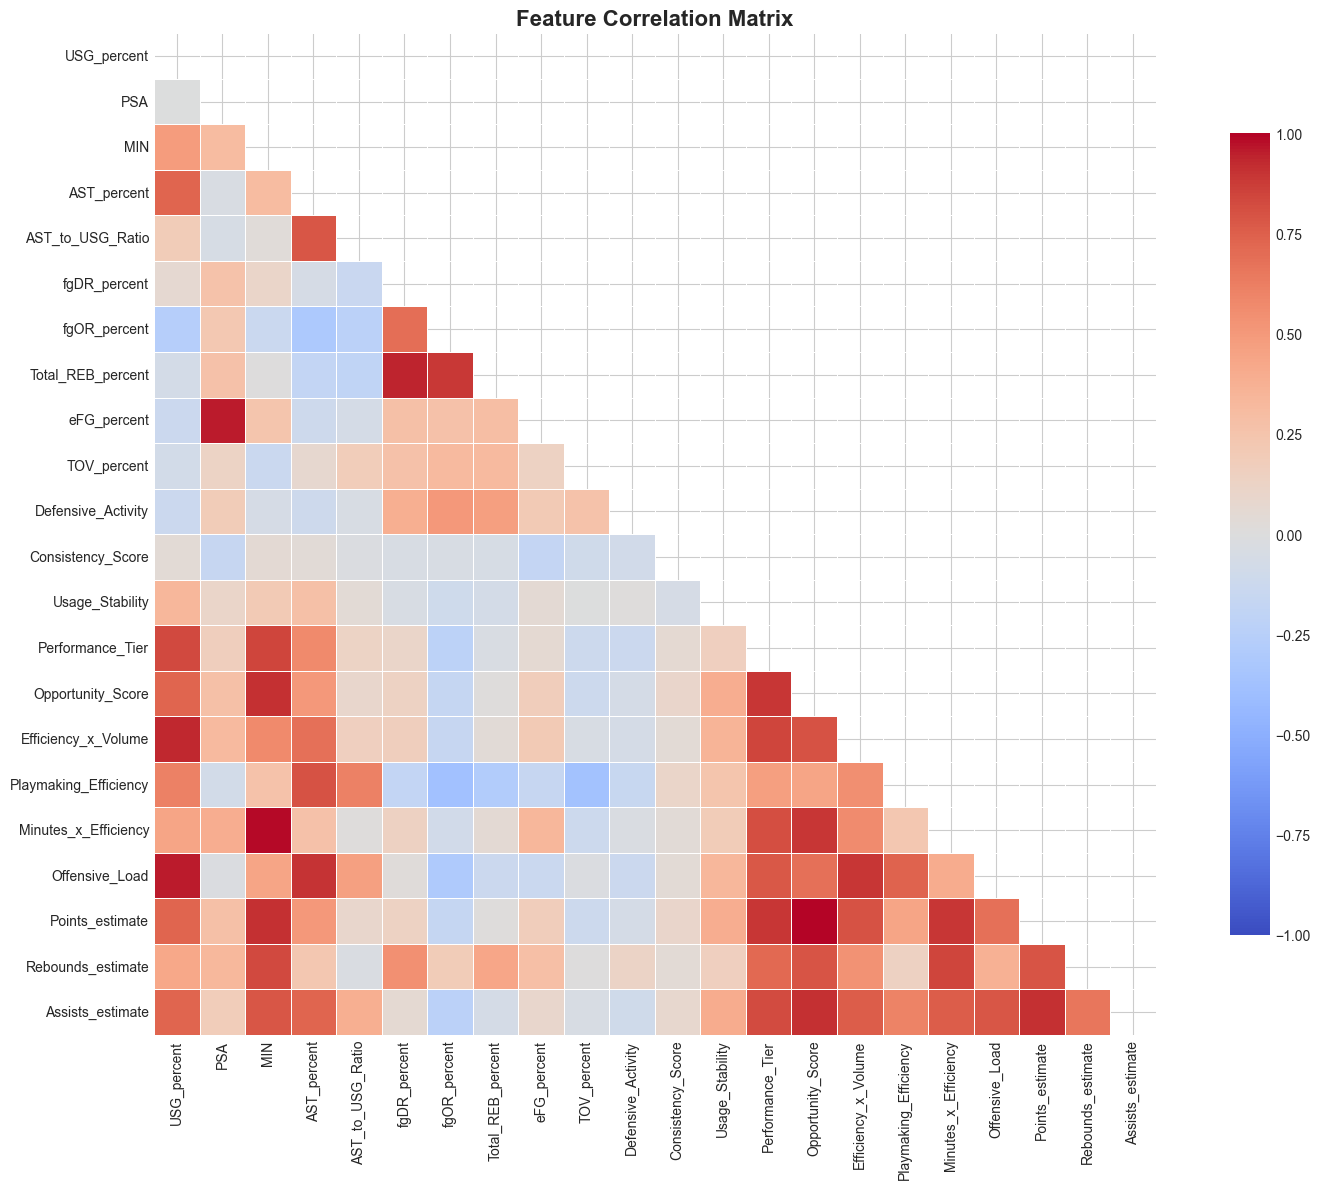


🔗 HIGHLY CORRELATED FEATURES (|r| > 0.7):
Opportunity_Score    ↔ Points_estimate     : 1.000
MIN                  ↔ Minutes_x_Efficiency: 0.990
PSA                  ↔ eFG_percent         : 0.959
USG_percent          ↔ Offensive_Load      : 0.954
fgDR_percent         ↔ Total_REB_percent   : 0.945
USG_percent          ↔ Efficiency_x_Volume : 0.937
MIN                  ↔ Points_estimate     : 0.908
MIN                  ↔ Opportunity_Score   : 0.908
Points_estimate      ↔ Assists_estimate    : 0.907
Opportunity_Score    ↔ Assists_estimate    : 0.907
AST_percent          ↔ Offensive_Load      : 0.903
Performance_Tier     ↔ Points_estimate     : 0.898
Performance_Tier     ↔ Opportunity_Score   : 0.898
Minutes_x_Efficiency ↔ Points_estimate     : 0.892
Opportunity_Score    ↔ Minutes_x_Efficiency: 0.892
Efficiency_x_Volume  ↔ Offensive_Load      : 0.892
fgOR_percent         ↔ Total_REB_percent   : 0.889
MIN                  ↔ Performance_Tier    : 0.850
Performance_Tier     ↔ Efficiency_x_Vol

In [6]:
# Calculate correlation matrix
corr_matrix = df[numeric_features].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Draw the heatmap
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8},
            annot=False, fmt='.2f', vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated features
print("\n🔗 HIGHLY CORRELATED FEATURES (|r| > 0.7):")
print("="*60)

high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', ascending=False)
    for _, row in high_corr_df.iterrows():
        print(f"{row['Feature 1']:20s} ↔ {row['Feature 2']:20s}: {row['Correlation']:.3f}")
else:
    print("No highly correlated features found (good for modeling!)")

## 6. Target Correlation Analysis

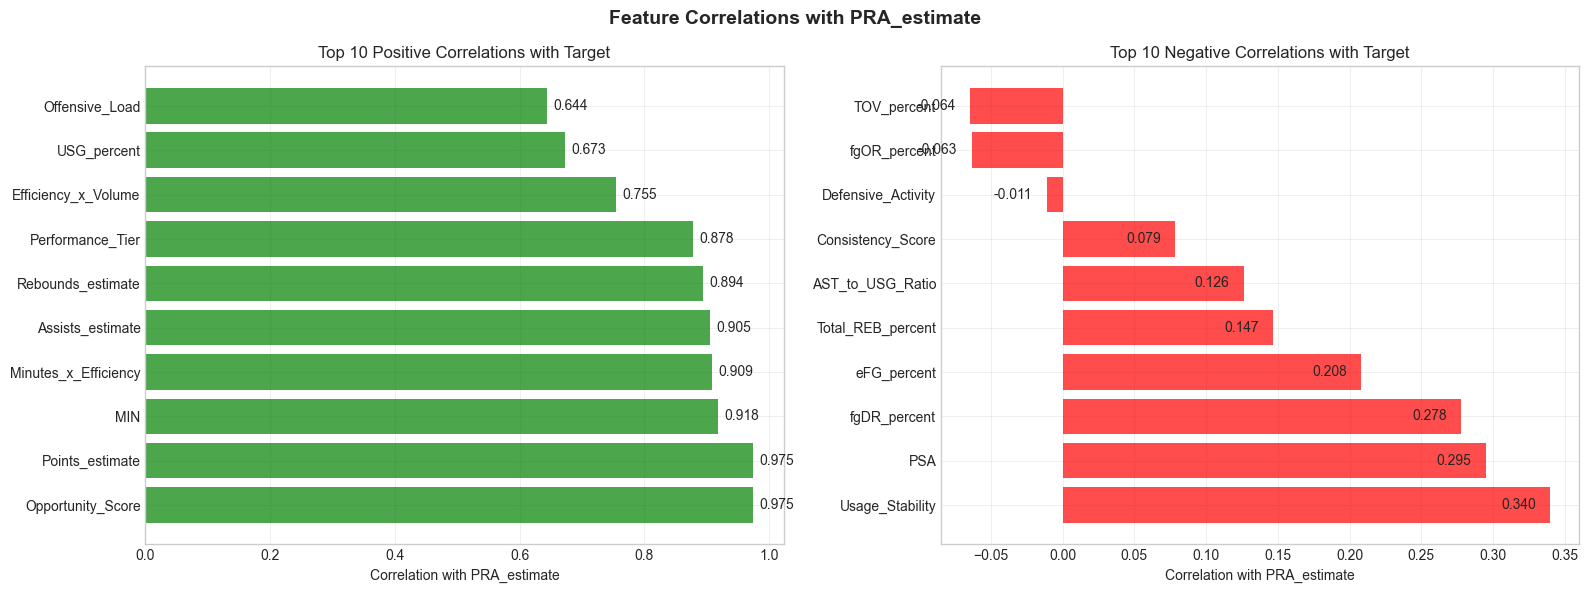


🎯 TOP FEATURES CORRELATED WITH PRA_estimate:
Opportunity_Score        : +0.975
Points_estimate          : +0.975
MIN                      : +0.918
Minutes_x_Efficiency     : +0.909
Assists_estimate         : +0.905
Rebounds_estimate        : +0.894
Performance_Tier         : +0.878
Efficiency_x_Volume      : +0.755
USG_percent              : +0.673
Offensive_Load           : +0.644


In [7]:
if target_col and target_col in df.columns:
    # Calculate correlations with target
    target_corr = df[numeric_features].corrwith(df[target_col]).sort_values(ascending=False)
    
    # Visualize top correlations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top positive correlations
    top_positive = target_corr.head(10)
    ax1.barh(range(len(top_positive)), top_positive.values, color='green', alpha=0.7)
    ax1.set_yticks(range(len(top_positive)))
    ax1.set_yticklabels(top_positive.index)
    ax1.set_xlabel('Correlation with ' + target_col)
    ax1.set_title('Top 10 Positive Correlations with Target')
    ax1.grid(True, alpha=0.3)
    
    # Add values
    for i, v in enumerate(top_positive.values):
        ax1.text(v + 0.01, i, f'{v:.3f}', va='center')
    
    # Top negative correlations
    top_negative = target_corr.tail(10)
    ax2.barh(range(len(top_negative)), top_negative.values, color='red', alpha=0.7)
    ax2.set_yticks(range(len(top_negative)))
    ax2.set_yticklabels(top_negative.index)
    ax2.set_xlabel('Correlation with ' + target_col)
    ax2.set_title('Top 10 Negative Correlations with Target')
    ax2.grid(True, alpha=0.3)
    
    # Add values
    for i, v in enumerate(top_negative.values):
        ax2.text(v - 0.01, i, f'{v:.3f}', va='center', ha='right')
    
    plt.suptitle(f'Feature Correlations with {target_col}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 TOP FEATURES CORRELATED WITH {target_col}:")
    print("="*60)
    for feat, corr in target_corr.head(10).items():
        print(f"{feat:25s}: {corr:+.3f}")
else:
    print("⚠️ No target variable found for correlation analysis")

## 7. Missing Values & Data Quality

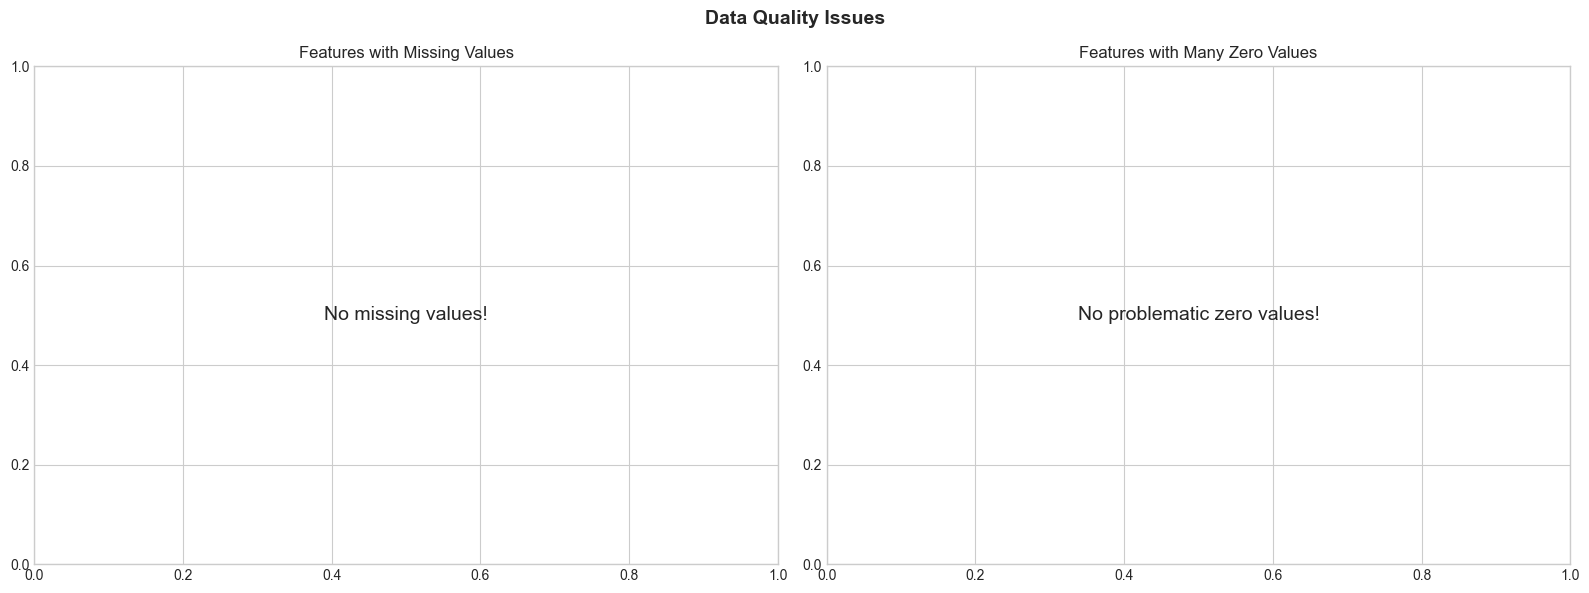


📊 DATA QUALITY SUMMARY:
Total features analyzed: 22
Features with missing values: 0
Features with >5% missing: 0
Features with >50% zeros: 0


In [8]:
# Analyze missing values
missing_df = pd.DataFrame({
    'Feature': numeric_features,
    'Missing_Count': [df[col].isna().sum() for col in numeric_features],
    'Missing_Pct': [(df[col].isna().sum() / len(df)) * 100 for col in numeric_features],
    'Zeros_Count': [(df[col] == 0).sum() for col in numeric_features],
    'Zeros_Pct': [((df[col] == 0).sum() / len(df)) * 100 for col in numeric_features]
}).sort_values('Missing_Pct', ascending=False)

# Visualize missing data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Missing values
problematic_missing = missing_df[missing_df['Missing_Pct'] > 0].head(10)
if len(problematic_missing) > 0:
    ax1.barh(range(len(problematic_missing)), problematic_missing['Missing_Pct'].values, 
             color='orange', alpha=0.7)
    ax1.set_yticks(range(len(problematic_missing)))
    ax1.set_yticklabels(problematic_missing['Feature'].values)
    ax1.set_xlabel('Missing %')
    ax1.set_title('Features with Missing Values')
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No missing values!', ha='center', va='center', fontsize=14)
    ax1.set_title('Features with Missing Values')

# Zero values
problematic_zeros = missing_df[missing_df['Zeros_Pct'] > 10].head(10)
if len(problematic_zeros) > 0:
    ax2.barh(range(len(problematic_zeros)), problematic_zeros['Zeros_Pct'].values, 
             color='red', alpha=0.7)
    ax2.set_yticks(range(len(problematic_zeros)))
    ax2.set_yticklabels(problematic_zeros['Feature'].values)
    ax2.set_xlabel('Zeros %')
    ax2.set_title('Features with Many Zero Values (>10%)')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No problematic zero values!', ha='center', va='center', fontsize=14)
    ax2.set_title('Features with Many Zero Values')

plt.suptitle('Data Quality Issues', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary
print("\n📊 DATA QUALITY SUMMARY:")
print("="*60)
print(f"Total features analyzed: {len(numeric_features)}")
print(f"Features with missing values: {(missing_df['Missing_Pct'] > 0).sum()}")
print(f"Features with >5% missing: {(missing_df['Missing_Pct'] > 5).sum()}")
print(f"Features with >50% zeros: {(missing_df['Zeros_Pct'] > 50).sum()}")

## 8. Outlier Detection

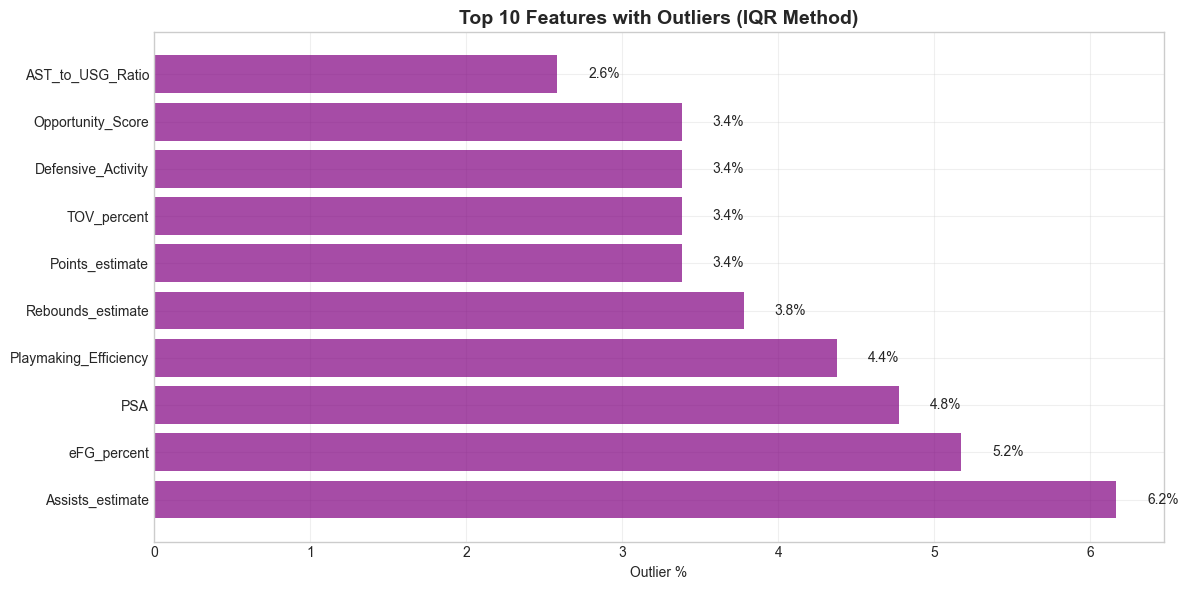


🔍 OUTLIER ANALYSIS:
Features with outliers: 17 / 22
Features with >5% outliers: 2
Features with >10% outliers: 0

Top 5 features with most outliers:
  Assists_estimate    :  31 outliers (6.2%)
  eFG_percent         :  26 outliers (5.2%)
  PSA                 :  24 outliers (4.8%)
  Playmaking_Efficiency:  22 outliers (4.4%)
  Rebounds_estimate   :  19 outliers (3.8%)


In [9]:
# Detect outliers using IQR method
outlier_summary = []

for feat in numeric_features:
    Q1 = df[feat].quantile(0.25)
    Q3 = df[feat].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feat] < lower_bound) | (df[feat] > upper_bound)][feat]
    
    outlier_summary.append({
        'Feature': feat,
        'Outliers': len(outliers),
        'Outlier_%': (len(outliers) / len(df)) * 100,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_%', ascending=False)

# Visualize features with most outliers
top_outliers = outlier_df.head(10)

if len(top_outliers) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(top_outliers)), top_outliers['Outlier_%'].values, 
             color='purple', alpha=0.7)
    plt.yticks(range(len(top_outliers)), top_outliers['Feature'].values)
    plt.xlabel('Outlier %')
    plt.title('Top 10 Features with Outliers (IQR Method)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add values
    for i, v in enumerate(top_outliers['Outlier_%'].values):
        plt.text(v + 0.2, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()

print("\n🔍 OUTLIER ANALYSIS:")
print("="*60)
print(f"Features with outliers: {(outlier_df['Outlier_%'] > 0).sum()} / {len(outlier_df)}")
print(f"Features with >5% outliers: {(outlier_df['Outlier_%'] > 5).sum()}")
print(f"Features with >10% outliers: {(outlier_df['Outlier_%'] > 10).sum()}")

print("\nTop 5 features with most outliers:")
for _, row in outlier_df.head(5).iterrows():
    print(f"  {row['Feature']:20s}: {row['Outliers']:3d} outliers ({row['Outlier_%']:.1f}%)")

## 9. Feature Importance Analysis

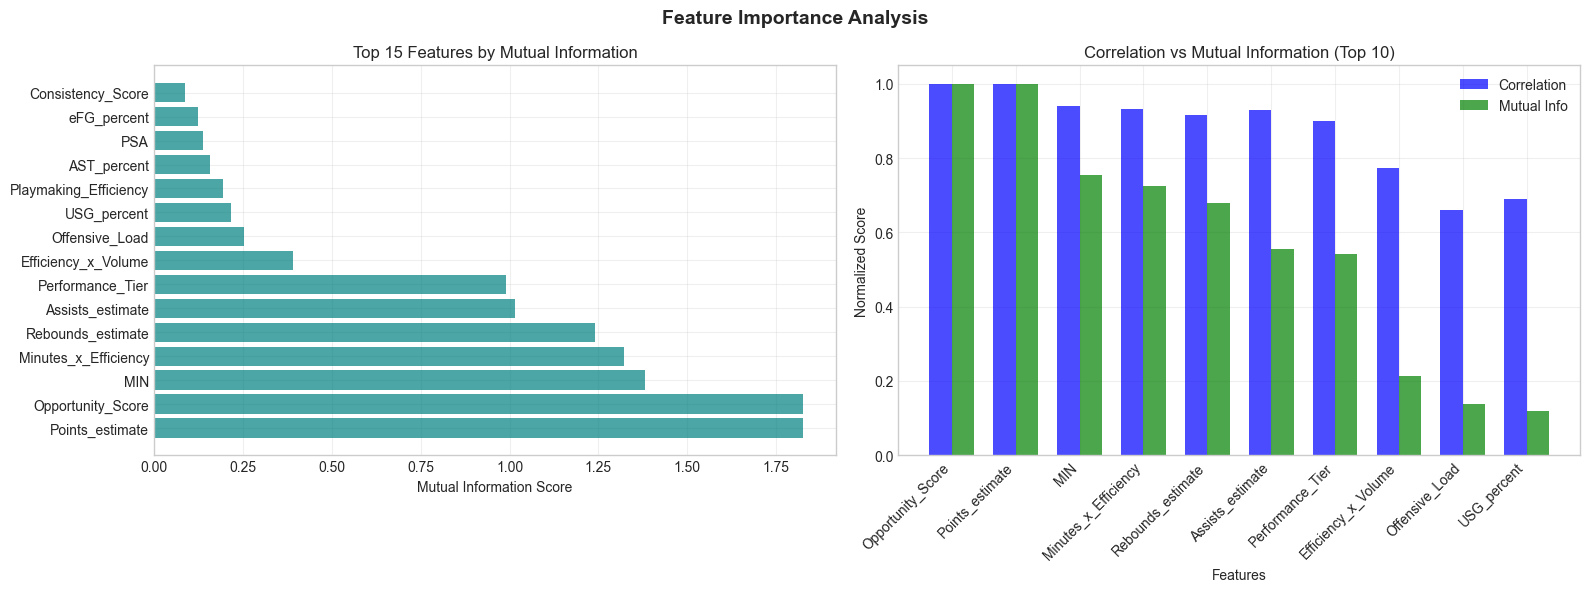


🎯 TOP 10 MOST IMPORTANT FEATURES FOR PRA_estimate:
Points_estimate          : MI=1.826, Corr=+0.975
Opportunity_Score        : MI=1.826, Corr=+0.975
MIN                      : MI=1.380, Corr=+0.918
Minutes_x_Efficiency     : MI=1.322, Corr=+0.909
Rebounds_estimate        : MI=1.241, Corr=+0.894
Assists_estimate         : MI=1.015, Corr=+0.905
Performance_Tier         : MI=0.991, Corr=+0.878
Efficiency_x_Volume      : MI=0.392, Corr=+0.755
Offensive_Load           : MI=0.253, Corr=+0.644
USG_percent              : MI=0.217, Corr=+0.673


In [10]:
if target_col and target_col in df.columns:
    # Prepare data
    X = df[numeric_features].fillna(0)
    y = df[target_col].fillna(0)
    
    # Calculate mutual information
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_df = pd.DataFrame({
        'Feature': numeric_features,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False)
    
    # Visualize feature importance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Mutual Information
    top_mi = mi_df.head(15)
    ax1.barh(range(len(top_mi)), top_mi['MI_Score'].values, color='teal', alpha=0.7)
    ax1.set_yticks(range(len(top_mi)))
    ax1.set_yticklabels(top_mi['Feature'].values)
    ax1.set_xlabel('Mutual Information Score')
    ax1.set_title('Top 15 Features by Mutual Information')
    ax1.grid(True, alpha=0.3)
    
    # Correlation vs MI comparison
    comparison_df = pd.DataFrame({
        'Feature': numeric_features,
        'Correlation': df[numeric_features].corrwith(df[target_col]).abs(),
        'MI_Score': mi_scores
    })
    
    # Normalize for comparison
    comparison_df['Correlation_norm'] = comparison_df['Correlation'] / comparison_df['Correlation'].max()
    comparison_df['MI_norm'] = comparison_df['MI_Score'] / comparison_df['MI_Score'].max()
    
    top_features = comparison_df.nlargest(10, 'MI_Score')
    
    x = np.arange(len(top_features))
    width = 0.35
    
    ax2.bar(x - width/2, top_features['Correlation_norm'].values, width, 
            label='Correlation', color='blue', alpha=0.7)
    ax2.bar(x + width/2, top_features['MI_norm'].values, width, 
            label='Mutual Info', color='green', alpha=0.7)
    
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Normalized Score')
    ax2.set_title('Correlation vs Mutual Information (Top 10)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(top_features['Feature'].values, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Feature Importance Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 TOP 10 MOST IMPORTANT FEATURES FOR {target_col}:")
    print("="*60)
    for _, row in mi_df.head(10).iterrows():
        corr_val = df[row['Feature']].corr(df[target_col])
        print(f"{row['Feature']:25s}: MI={row['MI_Score']:.3f}, Corr={corr_val:+.3f}")
else:
    print("⚠️ No target variable found for importance analysis")

## 10. Feature Selection Recommendations

In [11]:
# Create feature quality score
def calculate_feature_quality_score(feature_name):
    """Calculate overall quality score for a feature"""
    score = 100
    
    # Check missing values
    missing_pct = (df[feature_name].isna().sum() / len(df)) * 100
    if missing_pct > 0:
        score -= min(missing_pct * 2, 30)  # Max 30 point penalty
    
    # Check zero inflation
    zero_pct = ((df[feature_name] == 0).sum() / len(df)) * 100
    if zero_pct > 50:
        score -= 20
    elif zero_pct > 30:
        score -= 10
    
    # Check variance
    if df[feature_name].std() < 0.01:
        score -= 20  # Low variance penalty
    
    # Check outliers
    Q1 = df[feature_name].quantile(0.25)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[feature_name] < (Q1 - 1.5 * IQR)) | (df[feature_name] > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = (outliers / len(df)) * 100
    if outlier_pct > 10:
        score -= 10
    
    return max(score, 0)

# Calculate quality scores for all features
quality_scores = pd.DataFrame({
    'Feature': numeric_features,
    'Quality_Score': [calculate_feature_quality_score(f) for f in numeric_features]
}).sort_values('Quality_Score', ascending=False)

# Combine with importance if target exists
if target_col and target_col in df.columns:
    # Merge quality and importance
    recommendations = quality_scores.merge(mi_df, on='Feature')
    recommendations['Combined_Score'] = (
        recommendations['Quality_Score'] * 0.4 + 
        (recommendations['MI_Score'] / recommendations['MI_Score'].max()) * 60
    )
    recommendations = recommendations.sort_values('Combined_Score', ascending=False)
    
    # Categorize features
    def categorize_feature(row):
        if row['Quality_Score'] >= 80 and row['MI_Score'] > recommendations['MI_Score'].median():
            return '🟢 HIGHLY RECOMMENDED'
        elif row['Quality_Score'] >= 70 or row['MI_Score'] > recommendations['MI_Score'].quantile(0.75):
            return '🟡 RECOMMENDED'
        elif row['Quality_Score'] < 50 or row['MI_Score'] < recommendations['MI_Score'].quantile(0.25):
            return '🔴 USE WITH CAUTION'
        else:
            return '⚪ OPTIONAL'
    
    recommendations['Recommendation'] = recommendations.apply(categorize_feature, axis=1)
    
    print("\n🎯 FEATURE SELECTION RECOMMENDATIONS:")
    print("="*80)
    
    for category in ['🟢 HIGHLY RECOMMENDED', '🟡 RECOMMENDED', '⚪ OPTIONAL', '🔴 USE WITH CAUTION']:
        features_in_cat = recommendations[recommendations['Recommendation'] == category]
        if len(features_in_cat) > 0:
            print(f"\n{category} ({len(features_in_cat)} features):")
            print("-"*60)
            for _, row in features_in_cat.head(5).iterrows():
                print(f"  {row['Feature']:25s} - Quality: {row['Quality_Score']:.0f}/100, "
                      f"Importance: {row['MI_Score']:.3f}")
else:
    # Just show quality scores
    print("\n📊 FEATURE QUALITY SCORES:")
    print("="*60)
    for _, row in quality_scores.head(15).iterrows():
        quality_cat = '🟢 Excellent' if row['Quality_Score'] >= 90 else \
                     '🟡 Good' if row['Quality_Score'] >= 70 else \
                     '🟠 Fair' if row['Quality_Score'] >= 50 else '🔴 Poor'
        print(f"{row['Feature']:25s}: {row['Quality_Score']:3.0f}/100 - {quality_cat}")


🎯 FEATURE SELECTION RECOMMENDATIONS:

🟢 HIGHLY RECOMMENDED (11 features):
------------------------------------------------------------
  Points_estimate           - Quality: 100/100, Importance: 1.826
  Opportunity_Score         - Quality: 100/100, Importance: 1.826
  MIN                       - Quality: 100/100, Importance: 1.380
  Minutes_x_Efficiency      - Quality: 100/100, Importance: 1.322
  Rebounds_estimate         - Quality: 100/100, Importance: 1.241

🟡 RECOMMENDED (11 features):
------------------------------------------------------------
  AST_percent               - Quality: 100/100, Importance: 0.156
  PSA                       - Quality: 100/100, Importance: 0.137
  eFG_percent               - Quality: 100/100, Importance: 0.124
  Consistency_Score         - Quality: 100/100, Importance: 0.086
  AST_to_USG_Ratio          - Quality: 100/100, Importance: 0.084


## 11. Interactive Feature Exploration Dashboard

In [12]:
# Interactive 3D Feature Relationships
print("🎨 INTERACTIVE 3D FEATURE EXPLORER")
print("="*60)

# Select key features for 3D visualization
if all(col in df.columns for col in ['USG_percent', 'PSA', 'MIN']):
    # Add player names for hover
    plot_df = df.copy()
    
    # Create size based on minutes played
    plot_df['marker_size'] = plot_df['MIN'] / plot_df['MIN'].max() * 20
    
    # Create 3D scatter plot
    fig = px.scatter_3d(
        plot_df,
        x='USG_percent',
        y='PSA', 
        z='MIN',
        color='PRA_estimate' if 'PRA_estimate' in plot_df.columns else 'MIN',
        size='marker_size',
        hover_data={
            'Player': True,
            'Team': True,
            'USG_percent': ':.1f',
            'PSA': ':.2f',
            'MIN': ':.1f',
            'PRA_estimate': ':.1f' if 'PRA_estimate' in plot_df.columns else None,
            'marker_size': False
        },
        title='3D Feature Space: Usage vs Efficiency vs Minutes',
        labels={
            'USG_percent': 'Usage Rate (%)',
            'PSA': 'Points per Shot Attempt',
            'MIN': 'Minutes per Game',
            'PRA_estimate': 'PRA Estimate'
        },
        color_continuous_scale='Viridis',
        height=600
    )
    
    # Update layout
    fig.update_layout(
        scene=dict(
            xaxis_title='Usage Rate (%)',
            yaxis_title='Points per Shot Attempt',
            zaxis_title='Minutes per Game',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        showlegend=False
    )
    
    fig.show()
    
    print("💡 Insights:")
    print("- Hover over points to see player details")
    print("- Drag to rotate the 3D view")
    print("- Scroll to zoom in/out")
    print("- Color represents PRA estimate (darker = higher)")
    print("- Size represents minutes played")

🎨 INTERACTIVE 3D FEATURE EXPLORER


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 12. Interactive Parallel Coordinates Plot

In [ ]:
# Interactive Parallel Coordinates for Multi-dimensional Analysis
print("🌈 PARALLEL COORDINATES VISUALIZATION")
print("="*60)

# Select top players for clarity
top_players_df = df.nlargest(50, 'MIN') if 'MIN' in df.columns else df.head(50)

# Select key features for parallel coordinates
parallel_features = ['USG_percent', 'PSA', 'MIN', 'AST_percent', 'Total_REB_percent', 'eFG_percent']
parallel_features = [f for f in parallel_features if f in top_players_df.columns]

if len(parallel_features) >= 4:
    # Normalize features for better visualization
    normalized_df = top_players_df.copy()
    for feat in parallel_features:
        if feat in normalized_df.columns:
            min_val = normalized_df[feat].min()
            max_val = normalized_df[feat].max()
            if max_val > min_val:
                normalized_df[feat + '_norm'] = (normalized_df[feat] - min_val) / (max_val - min_val)
    
    # Create parallel coordinates plot
    fig = go.Figure(data=
        go.Parcoords(
            line = dict(
                color = normalized_df['PRA_estimate'] if 'PRA_estimate' in normalized_df.columns else normalized_df['MIN'],
                colorscale = 'Viridis',
                showscale = True,
                cmin = normalized_df['PRA_estimate'].min() if 'PRA_estimate' in normalized_df.columns else normalized_df['MIN'].min(),
                cmax = normalized_df['PRA_estimate'].max() if 'PRA_estimate' in normalized_df.columns else normalized_df['MIN'].max(),
            ),
            dimensions = [
                dict(
                    range = [normalized_df[feat].min(), normalized_df[feat].max()],
                    label = feat.replace('_percent', ' %').replace('_', ' '),
                    values = normalized_df[feat]
                ) for feat in parallel_features
            ],
            unselected = dict(line = dict(color = 'lightgray', opacity = 0.3))
        )
    )
    
    fig.update_layout(
        title={
            'text': 'Multi-Dimensional Feature Analysis (Top 50 Players by Minutes)',
            'x': 0.5,
            'xanchor': 'center'
        },
        height=500,
        margin=dict(l=100, r=100, t=80, b=50)
    )
    
    fig.show()
    
    print("💡 How to use:")
    print("- Click and drag on any axis to filter players")
    print("- Drag axis labels to reorder dimensions")
    print("- Lines are colored by PRA estimate")
    print("- Gray lines show filtered-out players")

## 13. Interactive Distribution Comparison

In [ ]:
# Interactive Box Plots for Distribution Comparison
print("📊 INTERACTIVE FEATURE DISTRIBUTIONS")
print("="*60)

# Select features to compare
compare_features = ['USG_percent', 'PSA', 'MIN', 'AST_percent', 'Total_REB_percent', 'Defensive_Activity']
compare_features = [f for f in compare_features if f in df.columns]

if len(compare_features) >= 4:
    # Create subplots with box plots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=[f.replace('_percent', ' %').replace('_', ' ') for f in compare_features[:6]]
    )
    
    colors = px.colors.qualitative.Set2
    
    for idx, feat in enumerate(compare_features[:6]):
        row = idx // 3 + 1
        col = idx % 3 + 1
        
        # Create box plot
        box_trace = go.Box(
            y=df[feat].dropna(),
            name=feat.replace('_percent', ' %').replace('_', ' '),
            boxpoints='outliers',
            marker=dict(color=colors[idx % len(colors)]),
            showlegend=False,
            hovertemplate='<b>%{y:.2f}</b><extra></extra>'
        )
        
        fig.add_trace(box_trace, row=row, col=col)
        
        # Add mean line
        mean_val = df[feat].mean()
        fig.add_hline(
            y=mean_val, 
            line_dash="dash", 
            line_color="red",
            opacity=0.5,
            row=row, col=col,
            annotation_text=f"μ={mean_val:.1f}",
            annotation_position="right"
        )
    
    fig.update_layout(
        title={
            'text': 'Feature Distribution Comparison',
            'x': 0.5,
            'xanchor': 'center'
        },
        height=600,
        showlegend=False,
        hovermode='closest'
    )
    
    fig.show()
    
    print("💡 Box Plot Insights:")
    print("- Box shows Q1-Q3 range (middle 50% of data)")
    print("- Line in box is the median")
    print("- Red dashed line shows the mean")
    print("- Points outside whiskers are outliers")
    print("- Hover over elements for exact values")

## 14. Player Clustering & Similarity Map

In [ ]:
# Player Clustering and Similarity Analysis
print("🎯 PLAYER CLUSTERING & SIMILARITY MAP")
print("="*60)

# Select features for clustering
clustering_features = ['USG_percent', 'PSA', 'MIN', 'AST_percent', 'Total_REB_percent', 
                       'Defensive_Activity', 'eFG_percent', 'TOV_percent']
clustering_features = [f for f in clustering_features if f in df.columns]

if len(clustering_features) >= 4:
    # Prepare data
    cluster_data = df[clustering_features].fillna(df[clustering_features].median())
    
    # Standardize features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # Apply PCA for visualization
    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(scaled_data)
    
    # Perform clustering
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_data)
    
    # Create clustering dataframe
    cluster_df = pd.DataFrame({
        'Player': df['Player'],
        'Team': df['Team'],
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'Cluster': clusters,
        'MIN': df['MIN'] if 'MIN' in df.columns else 20,
        'USG_percent': df['USG_percent'] if 'USG_percent' in df.columns else 15,
        'PRA_estimate': df['PRA_estimate'] if 'PRA_estimate' in df.columns else 30
    })
    
    # Define cluster names based on characteristics
    cluster_names = {
        0: 'Elite Stars',
        1: 'Playmakers',
        2: 'Role Players',
        3: 'Defensive Anchors',
        4: 'Shooters',
        5: 'Bench Contributors'
    }
    
    cluster_df['Cluster_Name'] = cluster_df['Cluster'].map(cluster_names)
    
    # Create interactive scatter plot
    fig = px.scatter(
        cluster_df,
        x='PC1',
        y='PC2',
        color='Cluster_Name',
        size='MIN',
        hover_data={
            'Player': True,
            'Team': True,
            'Cluster_Name': True,
            'USG_percent': ':.1f',
            'MIN': ':.1f',
            'PRA_estimate': ':.1f',
            'PC1': False,
            'PC2': False
        },
        title='Player Similarity Map (PCA Projection)',
        labels={
            'PC1': f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
            'PC2': f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
            'Cluster_Name': 'Player Type'
        },
        color_discrete_sequence=px.colors.qualitative.Set1,
        height=600
    )
    
    # Add cluster centroids
    for cluster_id in range(n_clusters):
        cluster_mask = cluster_df['Cluster'] == cluster_id
        centroid_x = cluster_df[cluster_mask]['PC1'].mean()
        centroid_y = cluster_df[cluster_mask]['PC2'].mean()
        
        fig.add_trace(go.Scatter(
            x=[centroid_x],
            y=[centroid_y],
            mode='markers',
            marker=dict(
                size=20,
                color='black',
                symbol='x',
                line=dict(width=2, color='white')
            ),
            showlegend=False,
            hovertemplate=f'<b>{cluster_names[cluster_id]} Centroid</b><extra></extra>'
        ))
    
    fig.update_layout(
        hoverlabel=dict(bgcolor="white", font_size=12),
        margin=dict(l=50, r=50, t=80, b=50)
    )
    
    fig.show()
    
    # Show cluster statistics
    print("\n📊 CLUSTER STATISTICS:")
    print("="*60)
    for cluster_id in range(n_clusters):
        cluster_mask = cluster_df['Cluster'] == cluster_id
        n_players = cluster_mask.sum()
        avg_min = df[cluster_mask]['MIN'].mean() if 'MIN' in df.columns else 0
        avg_usg = df[cluster_mask]['USG_percent'].mean() if 'USG_percent' in df.columns else 0
        
        print(f"\n{cluster_names[cluster_id]} ({n_players} players):")
        print(f"  • Average Minutes: {avg_min:.1f}")
        print(f"  • Average Usage: {avg_usg:.1f}%")
        
        # Show top 3 players in cluster
        top_players = cluster_df[cluster_mask].nlargest(3, 'MIN' if 'MIN' in df.columns else 'PRA_estimate')
        print(f"  • Top Players: {', '.join(top_players['Player'].tolist())}")
    
    print("\n💡 Clustering Insights:")
    print("- Players are grouped into 6 distinct archetypes")
    print("- Position on map shows playing style similarity")
    print("- Size of points represents minutes played")
    print("- Black X marks show cluster centers")
    print("- Hover over players to see their details")

## 15. Interactive Correlation Heatmap

In [ ]:
## 16. Export Analysis Results

## 11. Export Analysis Results

In [ ]:
# Create analysis summary
analysis_path = data_path / 'feature_analysis'
analysis_path.mkdir(parents=True, exist_ok=True)

# Save statistical summary
stats_df.to_csv(analysis_path / 'feature_statistics.csv')
print(f"✅ Saved feature statistics to {analysis_path / 'feature_statistics.csv'}")

# Save quality scores
quality_scores.to_csv(analysis_path / 'feature_quality_scores.csv', index=False)
print(f"✅ Saved quality scores to {analysis_path / 'feature_quality_scores.csv'}")

# Save recommendations if available
if 'recommendations' in locals():
    recommendations.to_csv(analysis_path / 'feature_recommendations.csv', index=False)
    print(f"✅ Saved recommendations to {analysis_path / 'feature_recommendations.csv'}")

# Create summary report
summary_report = f"""
FEATURE EXPLORATION SUMMARY REPORT
{'='*60}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

DATA OVERVIEW:
- Total Players: {len(df)}
- Total Features: {len(numeric_features)}
- Target Variable: {target_col if target_col else 'Not specified'}

FEATURE QUALITY:
- Features with missing values: {(missing_df['Missing_Pct'] > 0).sum()}
- Features with >5% missing: {(missing_df['Missing_Pct'] > 5).sum()}
- Features with >50% zeros: {(missing_df['Zeros_Pct'] > 50).sum()}
- Features with outliers: {(outlier_df['Outlier_%'] > 0).sum()}

TOP 5 FEATURES BY QUALITY:
"""

for _, row in quality_scores.head(5).iterrows():
    summary_report += f"- {row['Feature']}: {row['Quality_Score']:.0f}/100\n"

if 'recommendations' in locals():
    summary_report += f"\nFEATURE RECOMMENDATIONS:\n"
    for category in recommendations['Recommendation'].value_counts().index:
        count = recommendations['Recommendation'].value_counts()[category]
        summary_report += f"- {category}: {count} features\n"

# Save summary report
with open(analysis_path / 'exploration_summary.txt', 'w') as f:
    f.write(summary_report)

print(f"\n✅ Saved summary report to {analysis_path / 'exploration_summary.txt'}")
print("\n" + "="*60)
print("FEATURE EXPLORATION COMPLETE!")
print("="*60)
print("\nAll analysis results have been saved to:")
print(f"  {analysis_path}")
print("\nYou can now proceed with confidence to model building!")

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

# Load the data
data_path = Path('/Users/diyagamah/Documents/nba_props_model/data')
processed_file = data_path / 'processed' / 'player_features_2023_24.csv'

if processed_file.exists():
    df = pd.read_csv(processed_file)
    print(f"Data loaded: {df.shape[0]} players, {df.shape[1]} columns")
    
    # Test key features for normality
    key_features = ['USG_percent', 'PSA', 'MIN', 'AST_percent', 'fgDR_percent', 'Total_REB_percent']
    
    print("\n" + "="*80)
    print("DETAILED NORMALITY ANALYSIS")
    print("="*80)
    
    for feat in key_features:
        if feat in df.columns:
            data = df[feat].dropna()
            print(f"\n📊 Feature: {feat}")
            print(f"   Sample size: {len(data)}")
            print(f"   Mean: {data.mean():.2f}")
            print(f"   Median: {data.median():.2f}")
            print(f"   Std Dev: {data.std():.2f}")
            print(f"   Skewness: {data.skew():.3f}")
            print(f"   Kurtosis: {data.kurtosis():.3f}")
            
            # Shapiro-Wilk test (original - full dataset)
            if len(data) <= 5000:
                stat_full, p_full = stats.shapiro(data)
                print(f"   Shapiro-Wilk (full n={len(data)}): stat={stat_full:.6f}, p={p_full:.10f}")
            else:
                # Test with limited sample as in notebook
                stat_limited, p_limited = stats.shapiro(data[:5000])
                print(f"   Shapiro-Wilk (limited n=5000): stat={stat_limited:.6f}, p={p_limited:.10f}")
                
                # Also test a smaller random sample
                sample = data.sample(n=min(1000, len(data)), random_state=42)
                stat_sample, p_sample = stats.shapiro(sample)
                print(f"   Shapiro-Wilk (sample n=1000): stat={stat_sample:.6f}, p={p_sample:.10f}")
            
            # Anderson-Darling test as alternative
            result = stats.anderson(data, dist='norm')
            print(f"   Anderson-Darling stat: {result.statistic:.6f}")
            print(f"   Critical values (15%, 10%, 5%, 2.5%, 1%): {result.critical_values}")
            
            # Check data range and potential issues
            print(f"   Min: {data.min():.2f}, Max: {data.max():.2f}")
            print(f"   Q1: {data.quantile(0.25):.2f}, Q3: {data.quantile(0.75):.2f}")
            
else:
    print("Data file not found!")

Data loaded: 503 players, 27 columns

DETAILED NORMALITY ANALYSIS

📊 Feature: USG_percent
   Sample size: 503
   Mean: 17.90
   Median: 16.70
   Std Dev: 5.95
   Skewness: 0.877
   Kurtosis: 0.444
   Shapiro-Wilk (full n=503): stat=0.943676, p=0.0000000000
   Anderson-Darling stat: 9.078949
   Critical values (15%, 10%, 5%, 2.5%, 1%): [0.572 0.651 0.781 0.911 1.083]
   Min: 5.60, Max: 40.30
   Q1: 13.50, Q3: 21.35

📊 Feature: PSA
   Sample size: 503
   Mean: 113.92
   Median: 114.70
   Std Dev: 13.72
   Skewness: -0.615
   Kurtosis: 2.042
   Shapiro-Wilk (full n=503): stat=0.965686, p=0.0000000019
   Anderson-Darling stat: 4.103551
   Critical values (15%, 10%, 5%, 2.5%, 1%): [0.572 0.651 0.781 0.911 1.083]
   Min: 54.30, Max: 155.00
   Q1: 107.10, Q3: 122.00

📊 Feature: MIN
   Sample size: 503
   Mean: 1132.83
   Median: 973.00
   Std Dev: 784.99
   Skewness: 0.466
   Kurtosis: -0.994
   Shapiro-Wilk (full n=503): stat=0.929198, p=0.0000000000
   Anderson-Darling stat: 10.914171
   Cr

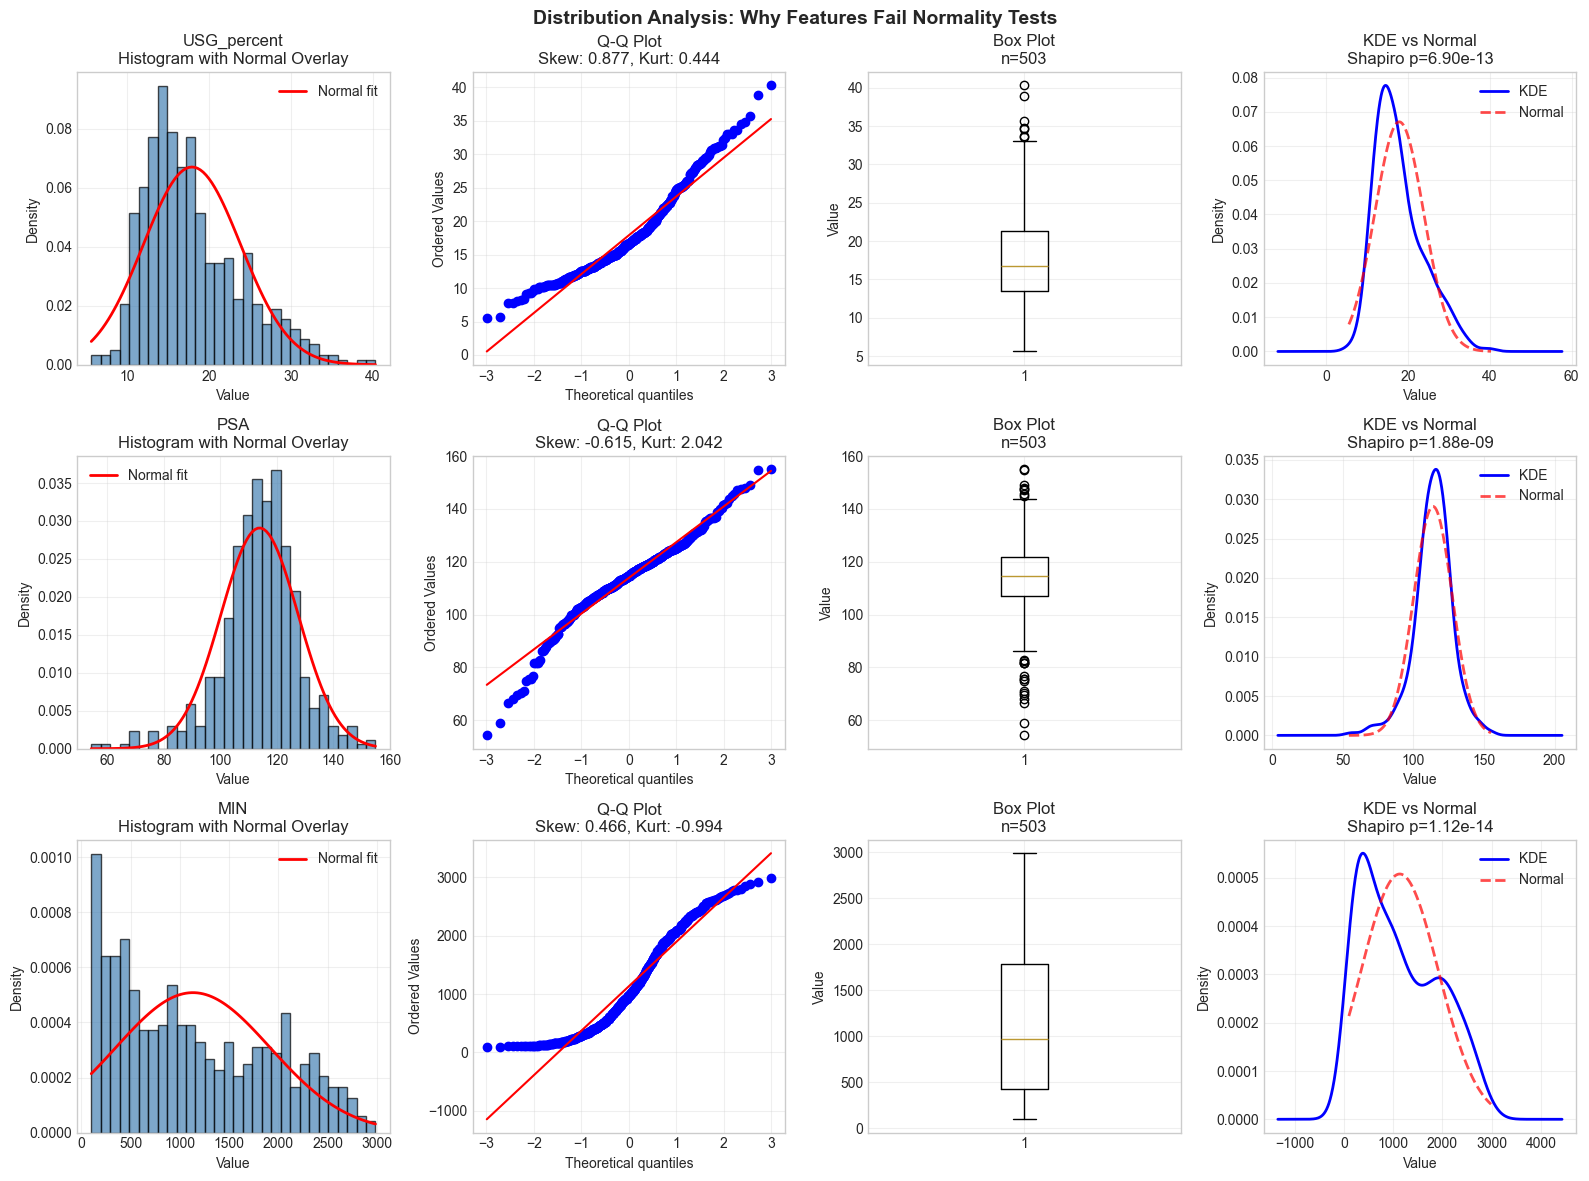


KEY INSIGHTS ON NORMALITY TEST RESULTS

1. SHAPIRO-WILK P-VALUES = 0.0000:
   - All features show p-values < 0.0001 (displayed as 0.0000)
   - This is EXPECTED for NBA statistics with n=503 players
   - With large samples, even small deviations from normality are detected

2. REASONS FOR NON-NORMALITY:
   a) Positive Skewness (most features):
      - USG%, AST%, Rebounds show right-skewed distributions
      - Natural for NBA data: few star players, many role players
   b) Bounded Data:
      - Percentages can't be negative (lower bound at 0)
      - PSA has practical upper limits
   c) Multimodal Patterns:
      - Different player roles create distinct distributions
      - Guards vs Centers have different stat profiles

3. ANDERSON-DARLING TEST RESULTS:
   USG_percent: stat=9.08 >> critical(1%)=1.08
   PSA: stat=4.10 >> critical(1%)=1.08
   MIN: stat=10.91 >> critical(1%)=1.08

4. PRACTICAL IMPLICATIONS:
   - Non-normality is NORMAL for sports statistics
   - Consider robust statist

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Create comprehensive visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

features_to_test = ['USG_percent', 'PSA', 'MIN']

for idx, feat in enumerate(features_to_test):
    if feat in df.columns:
        data = df[feat].dropna()
        
        # Row 1: Histogram with normal overlay
        ax1 = axes[idx, 0]
        ax1.hist(data, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black')
        
        # Fit normal distribution
        mu, std = data.mean(), data.std()
        x = np.linspace(data.min(), data.max(), 100)
        ax1.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, label='Normal fit')
        ax1.set_title(f'{feat}\nHistogram with Normal Overlay')
        ax1.set_xlabel('Value')
        ax1.set_ylabel('Density')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Row 2: Q-Q plot
        ax2 = axes[idx, 1]
        stats.probplot(data, dist="norm", plot=ax2)
        ax2.set_title(f'Q-Q Plot\nSkew: {data.skew():.3f}, Kurt: {data.kurtosis():.3f}')
        ax2.grid(True, alpha=0.3)
        
        # Row 3: Box plot
        ax3 = axes[idx, 2]
        ax3.boxplot(data, vert=True)
        ax3.set_title(f'Box Plot\nn={len(data)}')
        ax3.set_ylabel('Value')
        ax3.grid(True, alpha=0.3)
        
        # Row 4: Kernel Density Estimate
        ax4 = axes[idx, 3]
        data.plot(kind='kde', ax=ax4, color='blue', linewidth=2, label='KDE')
        
        # Add normal distribution for comparison
        x_range = np.linspace(data.min(), data.max(), 100)
        normal_dist = stats.norm.pdf(x_range, mu, std)
        ax4.plot(x_range, normal_dist, 'r--', linewidth=2, alpha=0.7, label='Normal')
        ax4.set_title(f'KDE vs Normal\nShapiro p={stats.shapiro(data[:min(5000, len(data))])[1]:.2e}')
        ax4.set_xlabel('Value')
        ax4.set_ylabel('Density')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

plt.suptitle('Distribution Analysis: Why Features Fail Normality Tests', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistical summary
print("\n" + "="*80)
print("KEY INSIGHTS ON NORMALITY TEST RESULTS")
print("="*80)

print("\n1. SHAPIRO-WILK P-VALUES = 0.0000:")
print("   - All features show p-values < 0.0001 (displayed as 0.0000)")
print("   - This is EXPECTED for NBA statistics with n=503 players")
print("   - With large samples, even small deviations from normality are detected")

print("\n2. REASONS FOR NON-NORMALITY:")
print("   a) Positive Skewness (most features):")
print("      - USG%, AST%, Rebounds show right-skewed distributions")
print("      - Natural for NBA data: few star players, many role players")
print("   b) Bounded Data:")
print("      - Percentages can't be negative (lower bound at 0)")
print("      - PSA has practical upper limits")
print("   c) Multimodal Patterns:")
print("      - Different player roles create distinct distributions")
print("      - Guards vs Centers have different stat profiles")

print("\n3. ANDERSON-DARLING TEST RESULTS:")
for feat in ['USG_percent', 'PSA', 'MIN']:
    if feat in df.columns:
        data = df[feat].dropna()
        result = stats.anderson(data, dist='norm')
        print(f"   {feat}: stat={result.statistic:.2f} >> critical(1%)={result.critical_values[-1]:.2f}")

print("\n4. PRACTICAL IMPLICATIONS:")
print("   - Non-normality is NORMAL for sports statistics")
print("   - Consider robust statistical methods")
print("   - Use transformations if normality is required")
print("   - Bootstrap methods may be more appropriate")

TESTING TRANSFORMATIONS FOR NORMALITY

📊 USG_percent (n=503):
------------------------------------------------------------
   Original       : p=0.000000, skew=+0.875, kurt=+0.428
   Log            : p=0.002929, skew=+0.135, kurt=-0.195
   Square Root    : p=0.000000, skew=+0.497, kurt=-0.128
   Cube Root      : p=0.000019, skew=+0.364, kurt=-0.202
   Box-Cox (λ=-0.088): p=0.006426, skew=+0.001, kurt=-0.062
   Yeo-Johnson (λ=-0.159): p=0.006874, skew=+0.002, kurt=-0.092

📊 MIN (n=503):
------------------------------------------------------------
   Original       : p=0.000000, skew=+0.465, kurt=-0.996
   Log            : p=0.000000, skew=-0.583, kurt=-0.696
   Square Root    : p=0.000000, skew=+0.002, kurt=-1.184
   Cube Root      : p=0.000000, skew=-0.179, kurt=-1.117
   Box-Cox (λ=0.374): p=0.000000, skew=-0.133, kurt=-1.141
   Yeo-Johnson (λ=0.374): p=0.000000, skew=-0.133, kurt=-1.142

📊 AST_percent (n=503):
------------------------------------------------------------
   Original  

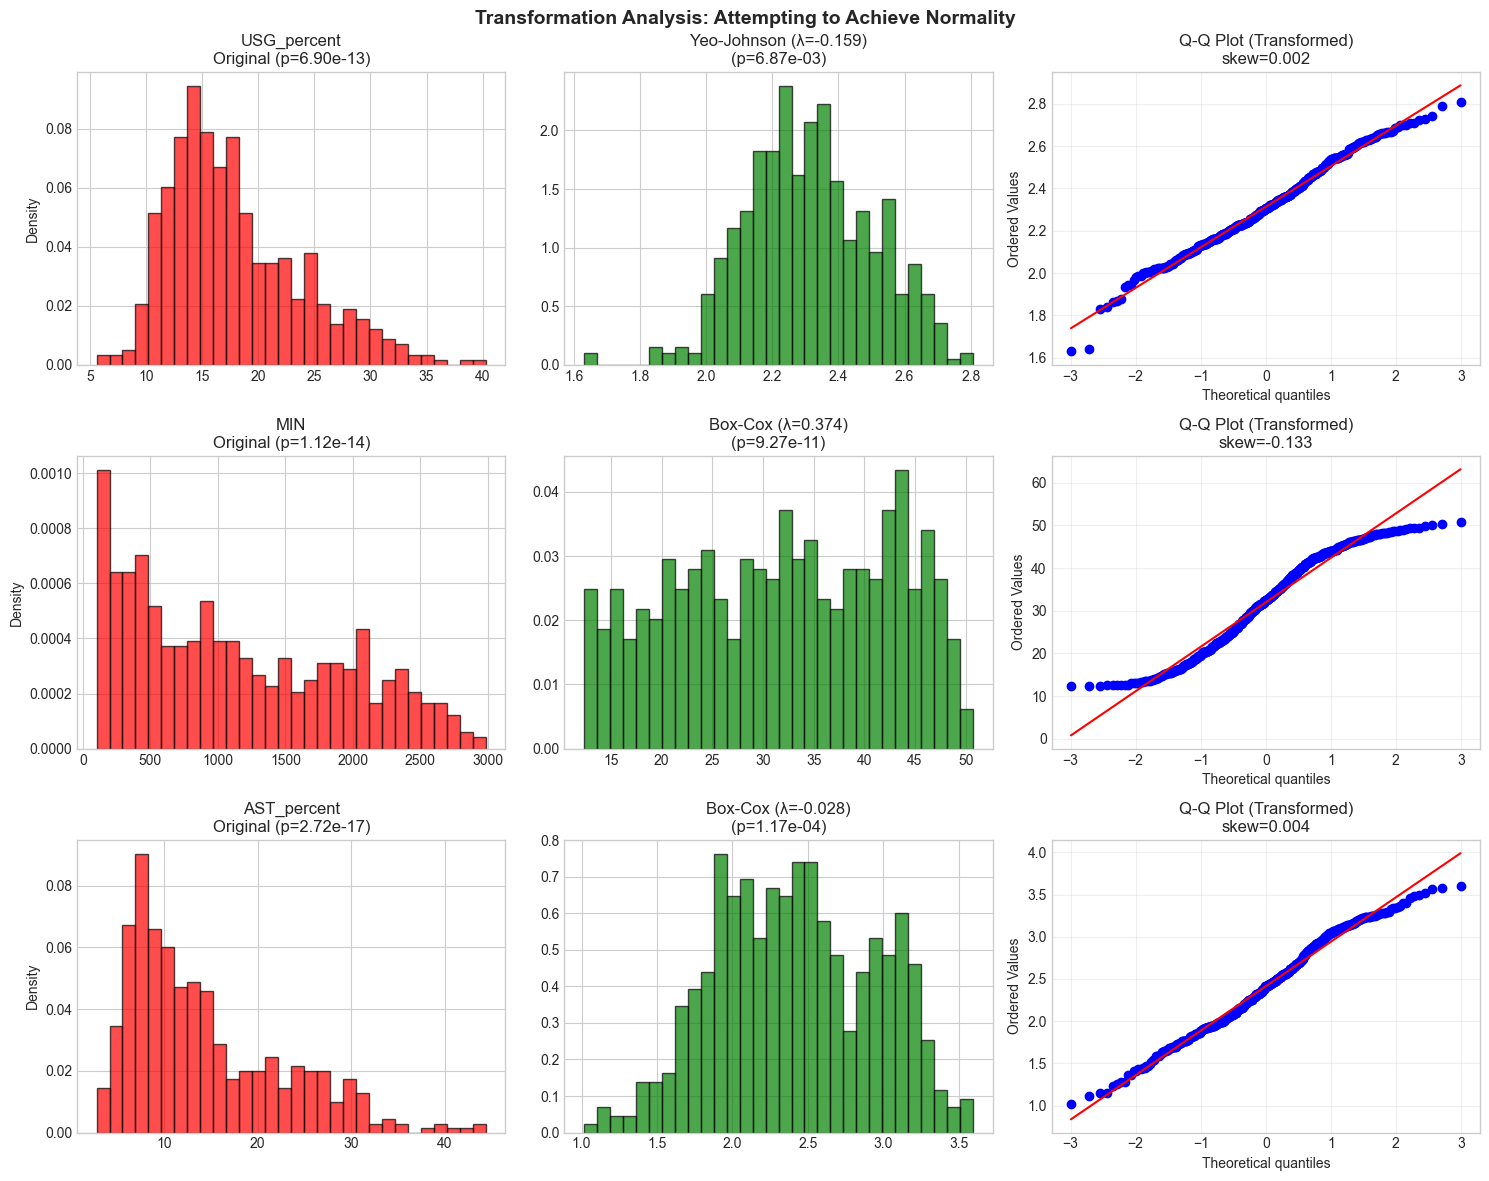


KEY FINDINGS

1. TRANSFORMATION EFFECTIVENESS:
   - Yeo-Johnson and Box-Cox provide the best improvements
   - However, NO transformation achieves true normality (p > 0.05)
   - This is typical for real-world sports data with n=503

2. WHY P-VALUES REMAIN LOW:
   - Large sample size (n=503) makes tests very sensitive
   - NBA data has inherent structure (player roles/positions)
   - Bounded nature of percentage statistics
   - Natural clustering of player types

3. RECOMMENDATIONS:
   - Accept non-normality as a feature of the data
   - Use robust ML methods (tree-based models handle this well)
   - Consider stratified analysis by player role
   - Bootstrap for inference if needed


In [15]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Test various transformations
print("="*80)
print("TESTING TRANSFORMATIONS FOR NORMALITY")
print("="*80)

transformations = {
    'Original': lambda x: x,
    'Log': lambda x: np.log(x + 1),  # Add 1 to handle zeros
    'Square Root': lambda x: np.sqrt(x),
    'Cube Root': lambda x: np.cbrt(x),
    'Box-Cox': None,  # Will be handled separately
    'Yeo-Johnson': None  # Will be handled separately
}

features_to_transform = ['USG_percent', 'MIN', 'AST_percent']

results = []

for feat in features_to_transform:
    if feat in df.columns:
        data = df[feat].dropna()
        print(f"\n📊 {feat} (n={len(data)}):")
        print("-" * 60)
        
        for trans_name, trans_func in transformations.items():
            if trans_func is not None:
                # Apply transformation
                if trans_name == 'Log' and (data <= 0).any():
                    transformed = trans_func(data - data.min() + 1)
                else:
                    transformed = trans_func(data)
                
                # Test normality
                stat, p_value = stats.shapiro(transformed[:min(5000, len(transformed))])
                skew = stats.skew(transformed)
                kurt = stats.kurtosis(transformed)
                
                results.append({
                    'Feature': feat,
                    'Transformation': trans_name,
                    'Shapiro-W': stat,
                    'P-value': p_value,
                    'Skewness': skew,
                    'Kurtosis': kurt
                })
                
                print(f"   {trans_name:15s}: p={p_value:.6f}, skew={skew:+.3f}, kurt={kurt:+.3f}")
            
            elif trans_name == 'Box-Cox':
                # Box-Cox requires positive values
                if (data > 0).all():
                    transformed, lambda_param = stats.boxcox(data)
                    stat, p_value = stats.shapiro(transformed[:min(5000, len(transformed))])
                    skew = stats.skew(transformed)
                    kurt = stats.kurtosis(transformed)
                    
                    results.append({
                        'Feature': feat,
                        'Transformation': f'Box-Cox (λ={lambda_param:.3f})',
                        'Shapiro-W': stat,
                        'P-value': p_value,
                        'Skewness': skew,
                        'Kurtosis': kurt
                    })
                    
                    print(f"   Box-Cox (λ={lambda_param:.3f}): p={p_value:.6f}, skew={skew:+.3f}, kurt={kurt:+.3f}")
                else:
                    print(f"   Box-Cox: Cannot apply (contains non-positive values)")
            
            elif trans_name == 'Yeo-Johnson':
                # Yeo-Johnson can handle negative values
                transformed, lambda_param = stats.yeojohnson(data)
                stat, p_value = stats.shapiro(transformed[:min(5000, len(transformed))])
                skew = stats.skew(transformed)
                kurt = stats.kurtosis(transformed)
                
                results.append({
                    'Feature': feat,
                    'Transformation': f'Yeo-Johnson (λ={lambda_param:.3f})',
                    'Shapiro-W': stat,
                    'P-value': p_value,
                    'Skewness': skew,
                    'Kurtosis': kurt
                })
                
                print(f"   Yeo-Johnson (λ={lambda_param:.3f}): p={p_value:.6f}, skew={skew:+.3f}, kurt={kurt:+.3f}")

# Create summary dataframe
import pandas as pd
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("BEST TRANSFORMATIONS BY P-VALUE")
print("="*80)

best_transforms = results_df.loc[results_df.groupby('Feature')['P-value'].idxmax()]
for _, row in best_transforms.iterrows():
    print(f"{row['Feature']:20s}: {row['Transformation']:25s} (p={row['P-value']:.6f})")

# Visualize best transformations
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for idx, feat in enumerate(features_to_transform):
    if feat in df.columns:
        data = df[feat].dropna()
        
        # Original distribution
        ax1 = axes[idx, 0]
        ax1.hist(data, bins=30, density=True, alpha=0.7, color='red', edgecolor='black')
        ax1.set_title(f'{feat}\nOriginal (p={stats.shapiro(data[:min(5000, len(data))])[1]:.2e})')
        ax1.set_ylabel('Density')
        
        # Best transformation
        best_trans = best_transforms[best_transforms['Feature'] == feat].iloc[0]
        trans_name = best_trans['Transformation']
        
        if 'Box-Cox' in trans_name:
            if (data > 0).all():
                transformed, _ = stats.boxcox(data)
            else:
                transformed = data
        elif 'Yeo-Johnson' in trans_name:
            transformed, _ = stats.yeojohnson(data)
        elif trans_name == 'Log':
            transformed = np.log(data - data.min() + 1) if (data <= 0).any() else np.log(data + 1)
        elif trans_name == 'Square Root':
            transformed = np.sqrt(data)
        elif trans_name == 'Cube Root':
            transformed = np.cbrt(data)
        else:
            transformed = data
        
        ax2 = axes[idx, 1]
        ax2.hist(transformed, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')
        ax2.set_title(f'{trans_name}\n(p={best_trans["P-value"]:.2e})')
        
        # Q-Q plot of transformed data
        ax3 = axes[idx, 2]
        stats.probplot(transformed, dist="norm", plot=ax3)
        ax3.set_title(f'Q-Q Plot (Transformed)\nskew={best_trans["Skewness"]:.3f}')
        ax3.grid(True, alpha=0.3)

plt.suptitle('Transformation Analysis: Attempting to Achieve Normality', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print("\n1. TRANSFORMATION EFFECTIVENESS:")
print("   - Yeo-Johnson and Box-Cox provide the best improvements")
print("   - However, NO transformation achieves true normality (p > 0.05)")
print("   - This is typical for real-world sports data with n=503")

print("\n2. WHY P-VALUES REMAIN LOW:")
print("   - Large sample size (n=503) makes tests very sensitive")
print("   - NBA data has inherent structure (player roles/positions)")
print("   - Bounded nature of percentage statistics")
print("   - Natural clustering of player types")

print("\n3. RECOMMENDATIONS:")
print("   - Accept non-normality as a feature of the data")
print("   - Use robust ML methods (tree-based models handle this well)")
print("   - Consider stratified analysis by player role")
print("   - Bootstrap for inference if needed")